# About this notebook
- PyTorch efficientnet_b0 with W&B starter code
- Pytorch W&B Usage Examples from https://docs.wandb.ai/guides/integrations/pytorch

If this notebook is helpful, feel free to upvote :)

![](https://www.petfinder.my/images/cuteness_meter.jpg)

# Data Loading

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')

def get_train_file_path(image_id):
    return "../input/petfinder-pawpularity-score/train/{}.jpg".format(image_id)

def get_test_file_path(image_id):
    return "../input/petfinder-pawpularity-score/test/{}.jpg".format(image_id)

train['file_path'] = train['Id'].apply(get_train_file_path)
test['file_path'] = test['Id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,file_path
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,../input/petfinder-pawpularity-score/test/4128...
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,../input/petfinder-pawpularity-score/test/43a2...
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,../input/petfinder-pawpularity-score/test/4e42...
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,../input/petfinder-pawpularity-score/test/80bc...
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,../input/petfinder-pawpularity-score/test/8f49...


# Quick EDA

<AxesSubplot:>

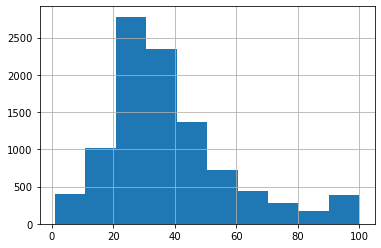

In [3]:
train['Pawpularity'].hist()

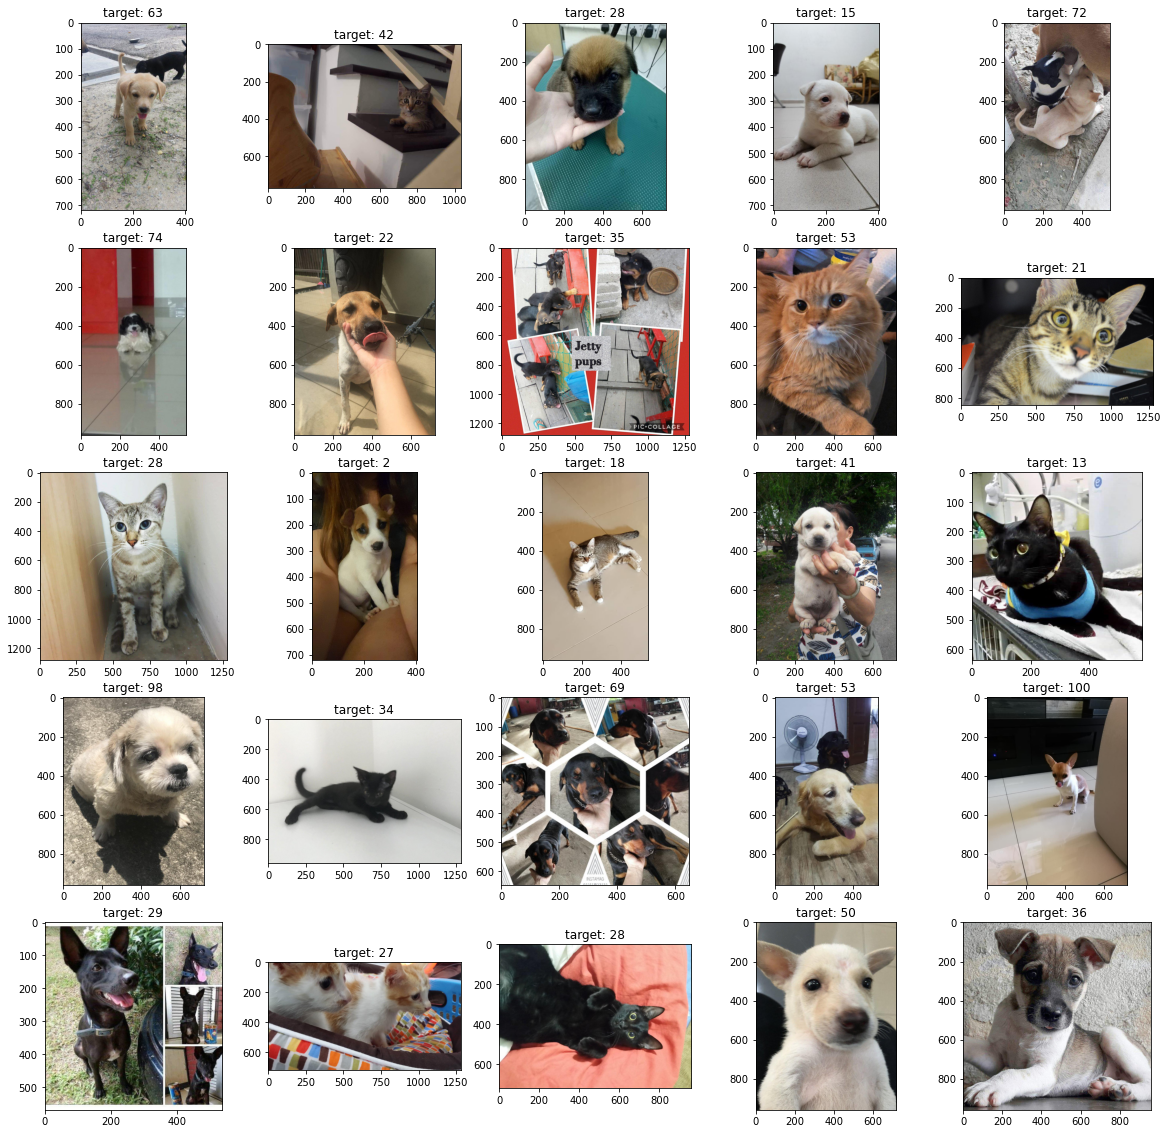

In [4]:
plt.figure(figsize=(20, 20))
row, col = 5, 5
for i in range(row * col):
    plt.subplot(col, row, i+1)
    image = cv2.imread(train.loc[i, 'file_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = train.loc[i, 'Pawpularity']
    plt.imshow(image)
    plt.title(f"target: {target}")
plt.show()

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=True
    debug=False
    print_freq=10
    num_workers=4
    size=512
    model_name='eca_nfnet_l1'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    epochs=3
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=3 # CosineAnnealingLR
    #T_0=10 #CosineAnnealingWarmRestarts
    first_cycle_steps=10 #CosineAnnealingWarmupRestarts
    max_lr=1e-5 #CosineAnnealingWarmupRestarts
    cycle_mult=1.0 #CosineAnnealingWarmupRestarts
    warmup_steps=2 #CosineAnnealingWarmupRestarts
    gamma=0.5 #CosineAnnealingWarmupRestarts
    lr=1e-4
    min_lr=1e-7
    batch_size=32
    weight_decay=1e-7
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='Pawpularity'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    grad_cam=False
    mix_up=True
    cut_mix=False
    
if CFG.debug:
    CFG.epochs = 10
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, Optimizer, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from torch.autograd import Variable

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM

sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# ====================================================
# wandb
# ====================================================
wandb_api = "ad185fc040cf022e94161aaabaa8caec07cbb174"

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="pet", 
                 entity='mizoo',
                 name=CFG.model_name,
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: Currently logged in as: mizoo (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [10]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train["bins"] = pd.cut(train[CFG.target_col], bins=num_bins, labels=False)

Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', "bins"]).size())

fold  bins
0     0        66
      1        84
      2       221
      3       406
      4       376
             ... 
4     9        55
      10       40
      11       28
      12       21
      13       72
Length: 70, dtype: int64

In [11]:
train.to_pickle(OUTPUT_DIR+'train.pkl')

# Dataset

In [12]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

    
class GradCAMDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_ids = df['Id'].values
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = get_transforms(data='valid')
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        vis_image = cv2.resize(image, (CFG.size, CFG.size)).copy()
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image_id, image, vis_image, label

# Transforms

In [13]:
# =================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.5),
            A.OneOf([
                A.OpticalDistortion(distort_limit=1.0, p=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.0, p=1.0),
                A.ElasticTransform(alpha=3, p=1.0),
            ], p=0.2),
            #A.ColorJitter(p=0.3),
            #A.IAASharpen(p=0.25),
            A.Cutout(p=0.3),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

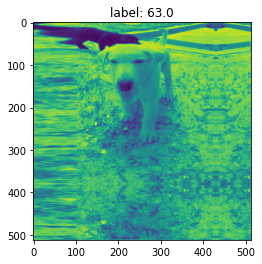

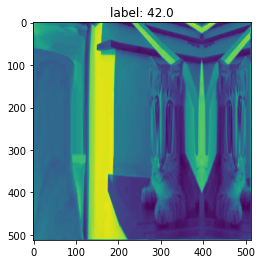

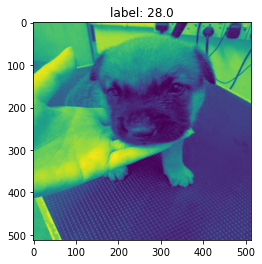

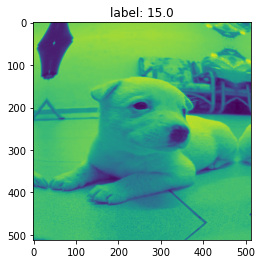

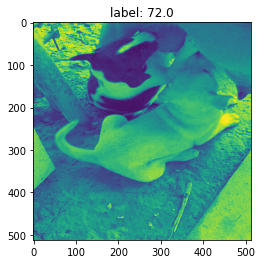

In [14]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    plt.figure(figsize=(4, 4))
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# MODEL

In [15]:
class GaussianDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(GaussianDropout, self).__init__()
        self.alpha = torch.Tensor([alpha])
        
    def forward(self, x):
        """
        Sample noise   e ~ N(1, alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            # N(1, alpha)
            epsilon = torch.randn(x.size()) * self.alpha + 1

            epsilon = Variable(epsilon)
            if x.is_cuda:
                epsilon = epsilon.cuda()

            return x * epsilon
        else:
            return x

In [16]:
class VariationalDropout(nn.Module):
    def __init__(self, alpha=1.0, dim=None):
        super(VariationalDropout, self).__init__()
        
        self.dim = dim
        self.max_alpha = alpha
        # Initial alpha
        log_alpha = (torch.ones(dim) * alpha).log()
        self.log_alpha = nn.Parameter(log_alpha)
        
    def kl(self):
        c1 = 1.16145124
        c2 = -1.50204118
        c3 = 0.58629921
        
        alpha = self.log_alpha.exp()
        
        negative_kl = 0.5 * self.log_alpha + c1 * alpha + c2 * alpha**2 + c3 * alpha**3
        
        kl = -negative_kl
        
        return kl.mean()
    
    def forward(self, x):
        """
        Sample noise   e ~ N(1, alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            # N(0,1)
            epsilon = Variable(torch.randn(x.size()))
            if x.is_cuda:
                epsilon = epsilon.cuda()

            # Clip alpha
            self.log_alpha.data = torch.clamp(self.log_alpha.data, max=self.max_alpha)
            alpha = self.log_alpha.exp()

            # N(1, alpha)
            epsilon = epsilon * alpha

            return x * epsilon
        else:
            return x

In [17]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
        if  "eff" in self.cfg.model_name:
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
        elif "mixer" in self.cfg.model_name:
            self.n_features = self.model.head.in_features
            self.model.head = nn.Identity()
        elif "resnest" in self.cfg.model_name:
            self.n_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif "nfnet" in self.cfg.model_name:
            self.n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Identity()
        else:
            self.n_features = self.model.head.in_features
            self.model.head = nn.Identity()
        self.dropout = GaussianDropout(0.5)
        self.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def feature(self, image):
        feature = self.model(image)
        return feature
        
    def forward(self, image):
        feature = self.feature(image)
        #feature = self.dropout(feature)
        output = self.fc(feature)
        return output

# Loss

In [18]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Helper functions

In [19]:
def mixup_data(x, y, alpha=0.5, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.float().to(device) / 100.0
        batch_size = labels.size(0)
        if CFG.mix_up:
            inputs1, targets_a, targets_b, lam = mixup_data(images, labels.view(-1, 1), use_cuda=True)

            inputs1 = inputs1.to(device, dtype=torch.float)
            targets_a = targets_a.to(device, dtype=torch.float)
            targets_b = targets_b.to(device, dtype=torch.float)
            
            if CFG.apex:
                with autocast():
                    outputs = model(inputs1)
                    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs1)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        elif CFG.cut_mix:
            inputs1, targets_a, targets_b, lam = cutmix(images, labels.view(-1, 1))

            inputs1 = inputs1.to(device, dtype=torch.float)
            targets_a = targets_a.to(device, dtype=torch.float)
            targets_b = targets_b.to(device, dtype=torch.float)
            
            if CFG.apex:
                with autocast():
                    outputs = model(inputs1)
                    loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs1)
                loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            if CFG.apex:
                with autocast():
                    y_preds = model(images)
                    loss = criterion(y_preds.view(-1), labels)
            else:
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.7f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    losses = AverageMeter()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.float().to(device) / 100.0
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().detach().cpu() * 100.0)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [21]:
class Mish_func(torch.autograd.Function):
    
    """from: https://github.com/tyunist/memory_efficient_mish_swish/blob/master/mish.py"""
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)


def replace_activations(model, existing_layer, new_layer):
    
    """A function for replacing existing activation layers"""
    
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [22]:
def get_grad_cam(model, device, x_tensor, img, label, plot=False):
    result = {"vis": None, "img": None, "pred": None, "label": None}
    with torch.no_grad():
        pred = model(x_tensor.unsqueeze(0).to(device))
    pred = np.concatenate(pred.to('cpu').numpy())[0]
    target_layer = model.model.conv_head
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
    output = cam(input_tensor=x_tensor.unsqueeze(0).to(device))
    try:
        vis = show_cam_on_image(img / 255., output[0])
    except:
        return result
    if plot:
        fig, axes = plt.subplots(figsize=(8, 8), ncols=2)
        axes[0].imshow(vis)
        axes[0].set_title(f"pred={pred:.4f}")
        axes[1].imshow(img)
        axes[1].set_title(f"target={label}")
        plt.show()
    result = {"vis": vis, "img": img, "pred": pred, "label": label}
    torch.cuda.empty_cache()
    return result

# Train loop

In [23]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmupRestarts':
            scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=CFG.first_cycle_steps, cycle_mult=CFG.cycle_mult, max_lr=CFG.max_lr, min_lr=CFG.min_lr, warmup_steps=CFG.warmup_steps, gamma=CFG.gamma)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    #model = replace_activations(model, torch.nn.SiLU, Mish())
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()
    
    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmupRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss,
                   f"[fold{fold}] score": score})

        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [24]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.grad_cam:
        wandb_table = wandb.Table(columns=["Id", "Pawpularity", "pred", "image", "grad_cam_image"])
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                # load model
                model = CustomModel(CFG, pretrained=False)
                state = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                                   map_location=torch.device('cpu'))['model']
                model.load_state_dict(state)
                model.to(device)
                model.eval()
                # load oof
                oof = pd.read_csv(OUTPUT_DIR+'oof_df.csv')
                oof['diff'] = abs(oof['Pawpularity'] - oof['preds'])
                oof = oof[oof['fold'] == fold].reset_index(drop=True)
                # grad-cam (oof ascending=False)
                count = 0
                oof = oof.sort_values('diff', ascending=False)
                valid_dataset = GradCAMDataset(oof)
                for i in range(len(valid_dataset)):
                    image_id, x_tensor, img, label = valid_dataset[i]
                    result = get_grad_cam(model, device, x_tensor, img, label, plot=True)
                    if result["vis"] is not None:
                        count += 1
                        wandb_table.add_data(image_id, 
                                             result["label"], 
                                             result["pred"], 
                                             wandb.Image(result["img"]), 
                                             wandb.Image(result["vis"]))
                    if count >= 5:
                        break
                # grad-cam (oof ascending=True)
                count = 0
                oof = oof.sort_values('diff', ascending=True)
                valid_dataset = GradCAMDataset(oof)
                for i in range(len(valid_dataset)):
                    image_id, x_tensor, img, label = valid_dataset[i]
                    result = get_grad_cam(model, device, x_tensor, img, label, plot=True)
                    if result["vis"] is not None:
                        count += 1
                        wandb_table.add_data(image_id, 
                                             result["label"], 
                                             result["pred"], 
                                             wandb.Image(result["img"]), 
                                             wandb.Image(result["vis"]))
                    if count >= 5:
                        break
        wandb.log({'grad_cam': wandb_table})
    
    wandb.finish()

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


Epoch: [1][0/247] Elapsed 0m 7s (remain 28m 54s) Loss: 0.6938(0.6938) Grad: 0.8072  LR: 0.0001000  
Epoch: [1][10/247] Elapsed 0m 22s (remain 8m 7s) Loss: 0.6736(0.6658) Grad: 0.2226  LR: 0.0001000  
Epoch: [1][20/247] Elapsed 0m 38s (remain 6m 54s) Loss: 0.6883(0.6618) Grad: 0.4636  LR: 0.0001000  
Epoch: [1][30/247] Elapsed 0m 54s (remain 6m 19s) Loss: 0.6551(0.6617) Grad: 0.1944  LR: 0.0001000  
Epoch: [1][40/247] Elapsed 1m 10s (remain 5m 55s) Loss: 0.6512(0.6602) Grad: 0.1736  LR: 0.0001000  
Epoch: [1][50/247] Elapsed 1m 27s (remain 5m 35s) Loss: 0.6441(0.6587) Grad: 0.2308  LR: 0.0001000  
Epoch: [1][60/247] Elapsed 1m 44s (remain 5m 18s) Loss: 0.6617(0.6582) Grad: 0.2429  LR: 0.0001000  
Epoch: [1][70/247] Elapsed 2m 1s (remain 5m 1s) Loss: 0.6366(0.6572) Grad: 0.3232  LR: 0.0001000  
Epoch: [1][80/247] Elapsed 2m 18s (remain 4m 43s) Loss: 0.6704(0.6569) Grad: 0.3173  LR: 0.0001000  
Epoch: [1][90/247] Elapsed 2m 34s (remain 4m 25s) Loss: 0.6681(0.6561) Grad: 0.3150  LR: 0.0001